# Learning of Material Properties via Gradient Descent

This notebook reproduces the results for the example application "Learning of radio materials" in the paper [Sionna RT: Differentiable Ray Tracing for Radio Propagation Modeling](https://arxiv.org/abs/2303.11103).

It requires [Sionna](https://github.com/NVlabs/sionna) v0.15 or later.


## Imports and GPU Configuration

In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Other imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sionna.rt import load_scene, RadioMaterial, PlanarArray, Transmitter, Receiver
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel

# Fix the seed for reproducible results
tf.random.set_seed(42)

## Configure the Scene and Generate Reference Data

In this example, we will load the scene "etoile" which is already available in Sionna.
We will then place a single transmitter and a few hundred receivers within the scene. The receiver locations define the points and which the channel impulse reponses will be computed.


In [2]:
def init_scene(rx_pos):
    """Load the scene, set materials and configure transmitter and receivers"""
    scene = load_scene(sionna.rt.scene.etoile)
    
    # Configure the transmit array
    scene.tx_array = PlanarArray(num_rows=1, num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="tr38901",
                                 polarization="V")
    
    # Configure the receive array (use by all receivers in the scene)
    scene.rx_array = PlanarArray(num_rows=1, num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")
    
    
    # Create a transmitter and add it to the scene
    tx = Transmitter("tx", position=[-302, 42, 23.0], orientation=[0,0,0])
    scene.add(tx)
    
    # Add receivers at the provided positions
    for i, pos in enumerate(rx_pos):
        rx = Receiver(f"rx+{i}", position=pos, orientation=[0,0,0])
        scene.add(rx)
        
    return scene

def update_rx_pos(scene, rx_pos):
    """Move the existing receivers in the scene to new positions"""
    for i, pos in enumerate(rx_pos):
        scene.get(f"rx+{i}").position = pos
        
def compute_h_freq(scene):
    """Compute the channel frequency responses for all receivers"""
    # Compute propagation paths
    # Note that we deactivate scattering and diffraction in this example
    paths = scene.compute_paths(max_depth=3, num_samples=1e6, scattering=False, diffraction=False)
    
    # Convert paths to channel impulse responses
    a, tau = paths.cir()
    
    # Convert to channel frequency responses
    h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)
    
    return tf.squeeze(h_freq)

Next, we will simulate channel impulse responses at all receiver locations and convert them to the frequency domain, assuming that perfect channel estimation is available using OFDM. These channel frequency responses will be our *measurements* or labels. 

In [3]:
# Receiver positions
rx_pos = np.zeros([400, 3])
for i in range(0,130,1):
    rx_pos[i] = [-195+i, 125, 1.5]
for i in range(130,280, 1):
    rx_pos[i] = [-66, 125-i+129, 1.5]
for i in range(280,400,1):
    rx_pos[i] = [-66+i-280, -26, 1.5]

# OFDM parameters
num_subcarriers = 128
subcarrier_spacing = 30e3
frequencies = subcarrier_frequencies(num_subcarriers,
                                     subcarrier_spacing)
max_num_rx = 100
scene = init_scene(rx_pos[:max_num_rx])

h_freq = np.zeros([400, num_subcarriers], np.complex64)
for i in range(int(400/max_num_rx)):
    update_rx_pos(scene, rx_pos[max_num_rx*i:max_num_rx*(i+1)])
    h_freq[max_num_rx*i:max_num_rx*(i+1)] = compute_h_freq(scene)

Let us visualize the scene with all receiver positions:

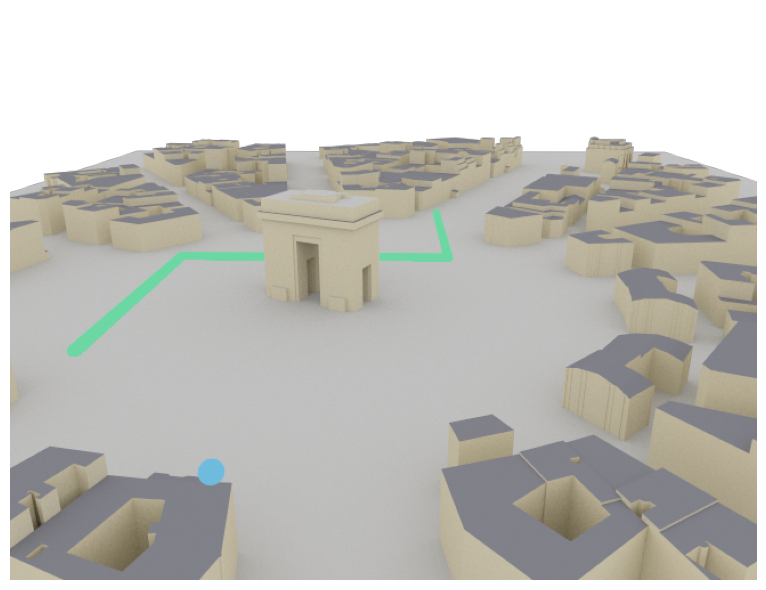

In [4]:
# Preview the scene
# The transmitter is indicated by a blue ball, the receivers by green balls
scene = init_scene(rx_pos)
scene.render("scene-cam-0", fov=60);

# You can launch an interactive preview like this:
#scene.preview()

## Replace Materials by Trainable Materials

We assume now that the radio materials in the scene are unknown and replace them by trainable materials that are initialized with some default value.

Let us first check which materials are used in the scene and how many objects are made of each of them:

In [5]:
for mat in list(scene.radio_materials.values()):
    if mat.is_used:
        print(f"Name: {mat.name}, Used by {mat.use_counter} scene objects.")

Name: itu_concrete, Used by 2 scene objects.
Name: itu_wood, Used by 1 scene objects.
Name: itu_marble, Used by 280 scene objects.
Name: itu_metal, Used by 280 scene objects.


In this scene, the street level is made of concrete. All building walls are made of marble, the roofs are made of metal, and a single object, namely the Arc de Triomphe, has a small part made of wood (to be precise, it is the ceiling inside it).

Next, we create for each of these materials a trainable replacement and assign it to the corresponding objects.
We could have also assigned to every object its own trainable material. This makes the training much longer and is out of the scope of this notebook.

In [7]:
num_rx = 64 # maximum number of receiver positions to be used during training, i.e., the batch size

scene = init_scene(rx_pos[:num_rx])

# Create for every used material a trainable material

# Some lists for book-keeping
original_materials = []
trainable_materials = []

for mat in scene.radio_materials.values():
    if mat.is_used:        
        # Create new trainable material with some default values
        new_mat = RadioMaterial(mat.name + "_train",
                                relative_permittivity=3.0,
                                conductivity=0.1,
                                trainable_relative_permittivity=True,
                                trainable_conductivity=True)
        scene.add(new_mat)
        trainable_materials.append(new_mat)
        original_materials.append(mat)
        
# Assign trainable materials to the corresponding objects
for obj in scene.objects.values():
    obj.radio_material = obj.radio_material.name + "_train"

TypeError: RadioMaterial.__init__() got an unexpected keyword argument 'trainable_relative_permittivity'

Let's check if the radio materials have been correctly replaced:

In [8]:
for mat in list(scene.radio_materials.values()):
    if mat.is_used:
        print(f"Name: {mat.name}, Used by {mat.use_counter} scene objects.")

Name: itu_concrete, Used by 2 scene objects.
Name: itu_wood, Used by 1 scene objects.
Name: itu_marble, Used by 280 scene objects.
Name: itu_metal, Used by 280 scene objects.


The constituent parameters of a material can be accessed as follows. For a definition, please have a look at the [Sionna documentation](https://nvlabs.github.io/sionna/em_primer.html#planar-time-harmonic-waves).

In [9]:
print(scene.radio_materials["itu_concrete"].relative_permittivity)
print(scene.radio_materials["itu_concrete"].conductivity)
print(scene.radio_materials["itu_concrete"].complex_relative_permittivity)

tf.Tensor(5.24, shape=(), dtype=float32)
tf.Tensor(0.123086944, shape=(), dtype=float32)
tf.Tensor((5.24-0.63214296j), shape=(), dtype=complex64)


## Learn Radio Material Properties by Gradient Descent

Now, we will try to recover the original material properties by comparing channel frequency responses generated by the trainable materials to those generated by the original materials, i.e., our *measured* data set. This will be done via gradient descent on the normalized mean squared error.

In [10]:
# Configure an optimizer (note that we use a very agressive learning rate here)
optimizer = tf.keras.optimizers.Adam(0.5)

num_steps = 100 # Number of training steps

# Placeholders to visualize training progress later
conductivities = np.zeros([num_steps, len(trainable_materials)])
relative_permittivities = np.zeros([num_steps, len(trainable_materials)])
scattering_coefficients = np.zeros([num_steps, len(trainable_materials)])
xpd_coefficients = np.zeros([num_steps, len(trainable_materials)])

def train_step():
    """A single training step"""
    with tf.GradientTape() as tape:
        
        # Move receivers to randomly chosen positions
        indices = tf.range(400)
        shuffled_indices = tf.random.shuffle(indices)
        indices = shuffled_indices[:num_rx]
        update_rx_pos(scene, tf.gather(rx_pos, indices))
        
        # Compute channel frequency responses
        h_freq_hat = compute_h_freq(scene)
        
        # Get target values
        h_freq_target = tf.gather(h_freq, indices)
        
        # Compute normalized MSE
        loss = tf.reduce_mean(tf.abs(h_freq_hat-h_freq_target)**2)/tf.reduce_mean((tf.abs(h_freq_target)**2))
    
    grads = tape.gradient(loss, tape.watched_variables(), unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

def check_mat(mat):
    """We need to make sure that material properties are always valid"""
    if mat.conductivity < 0: # Non-negative conductivity
        mat.conductivity = 0 
    if mat.relative_permittivity < 1: # Relative permittivity not smaller than 1
        mat.relative_permittivity = 1

for step in range(num_steps):       
    loss = train_step()
    print(f"Training step {step} - NMSE (dB) : {10*np.log10(loss.numpy())}", end="\r")
    
    for i, mat in enumerate(trainable_materials):
        check_mat(mat)
        conductivities[step, i] = mat.conductivity
        relative_permittivities[step, i] = mat.relative_permittivity
        scattering_coefficients[step, i] = mat.scattering_coefficient
        xpd_coefficients[step, i] = mat.xpd_coefficient

KeyboardInterrupt: 

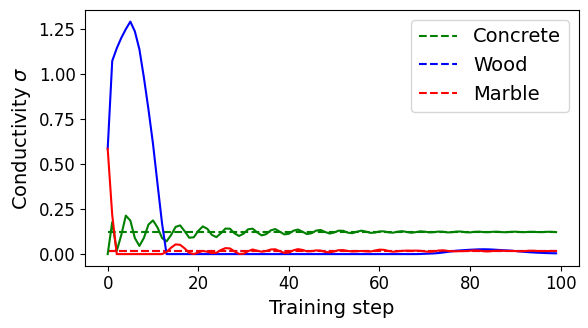

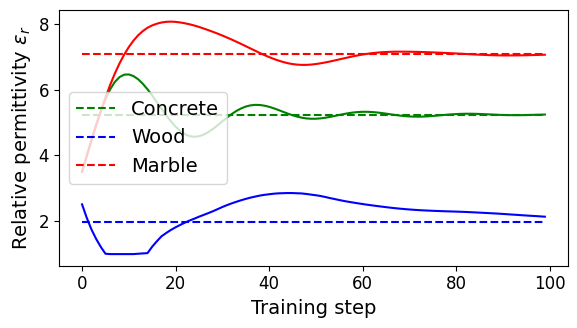

In [10]:
plt.rc('font', size=14)          
plt.rc('axes', titlesize=14)     
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=12)    
plt.rc('ytick', labelsize=12)   
plt.rc('legend', fontsize=14)    

plt.figure(figsize=(6,3.5))
colors = ["g", "b", "red"]
for i in range(3):
    plt.plot(np.repeat(original_materials[i].conductivity, num_steps), '--', color=colors[i])
for i in range(3):
    plt.plot(conductivities[:,i], '-', color=colors[i])
plt.xlabel("Training step")
plt.ylabel(r"Conductivity $\sigma$")
plt.legend(["Concrete", "Wood", "Marble"]);
plt.tight_layout()

plt.figure(figsize=(6,3.5))
colors = ["g", "b", "red"]
for i in range(3):
    plt.plot(np.repeat(original_materials[i].relative_permittivity, num_steps), '--', color=colors[i])
for i in range(3):
    plt.plot(relative_permittivities[:,i], '-', color=colors[i])
plt.xlabel("Training step")
plt.ylabel(r"Relative permittivity $\varepsilon_r$")
plt.legend(["Concrete", "Wood", "Marble"]);
plt.tight_layout()

## Discussion

Learning of materials via gradient descent works nicely in this scenario, as can be seen from the results above. Surprisingly, even the material "Wood" which is only used by a single object can be learned with high precision, although it requires more training steps.

- Note that only specular reflections are considered in this notebook. Studying the impact of other propagation effects on the learning process, such as refraction, diffraction, and scattering, are interesting future investigations.

- We have trained here on channel frequency responses. It is unlikely that this approach would work with measured data, as accurate phase information can rarely be predicted via ray tracing. A more practical approach could be to train on coverage maps. This is an open research field and many other options are possible.

- We have assumed here that many objects in the scene share the same materials. In practice, this is not the case, and one could assign a different material to each object or groups of objects. This will then increase the training complexity.

- One could use computer vision methods to assign coarse estimates of material properties to all objects in a scene. These could then be fine-tuned via learning.

- Learning of radio materials can be seen as an automated *calibration* of a ray tracer to measurements. It is hence an important step toward the creation of digital twin networks.